In [2]:
import utils
import numpy as np
import matplotlib.pyplot as plt

# FS 25 Simulations in Science II # 


## Instructions Task 1.0 ## 

- Implement a particle class and a cell class 
- Implement the partitioning of particles function we introduced in class. 
- The hard part is making sure your partition function is really bomb proof, check all "edge cases" (e.g., no particles in the cell, all particles on one side or other of the partition, already partitioned data, particles in the inverted order of the partition, etc...).
- Write boolean test functions for each of these cases.
- Call all test functions in sequence and check if they all succeed.
- Once you have this, then recursively partition the partitions and build cells linked into a tree as you go. Partition alternately in x and y dimensions, or simply partition the longest dimension of the given cell.
- Create a random distribution of particles in 2D and build a tree from the particles.
- Plot the particles and tree cells.

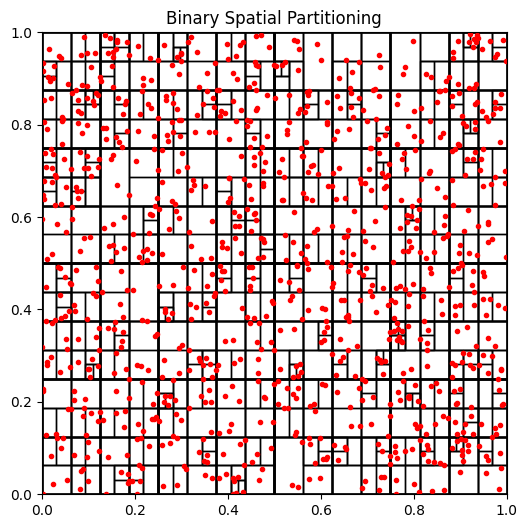

In [5]:
#Create create a number of random point between (0,0) and (1,1)
particles = [utils.Particle(np.random.rand(), np.random.rand()) for _ in range (1000)]

root_cell = utils.Cell(0, 0, 1, 1, particles) 

root_cell.split_cell(True, 4)

# Create plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Binary Spatial Partitioning")

# Plot cells and particles
utils.plot_cells(ax, root_cell)

plt.show()

